# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

##### Description
This notebook contains code for:
- Compare LVM, LVM + self-coupling, full GLM coupling to explain correlations
- Neural data is synthetic Gaussian place field population with low dimensional correlations and real place field data

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
#jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/filters/FIR.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Count processes

In [12]:
neurons = 3
tbin = 0.01  # s

count_type = 'nb'

if count_type == 'p':
    count = lib.likelihoods.factorized.Poisson(
        neurons,
        tbin,
    )
    
elif count_type == 'zip':
    alpha = np.linspace(0.0, 0.95, neurons)
    count = lib.likelihoods.factorized.ZeroInflatedPoisson(
        neurons,
        tbin,
        alpha,
    )
    
elif count_type == 'nb':
    r_inv = np.linspace(0.0, 1.5, neurons)
    count = lib.likelihoods.factorized.NegativeBinomial(
        neurons,
        tbin,
        r_inv,
    )
    
elif count_type == 'cmp':
    nu = np.linspace(0.5, 1.5, neurons)
    count = lib.likelihoods.factorized.ConwayMaxwellPoisson(
        neurons,
        tbin,
        nu,
    )

In [13]:
y = jnp.arange(0, 20)[:, None].repeat(neurons, axis=1)
f = jnp.linspace(6, 6, neurons)

log_p_y = jax.vmap(count.log_likelihood, (None, 0), 0)(f, y)

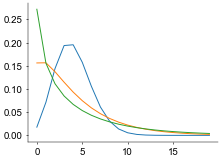

In [14]:
plt.plot(np.exp(log_p_y))

In [143]:
jnp.exp(f)

DeviceArray([403.4288, 403.4288, 403.4288], dtype=float32)

<a id='glm'></a>
## GLM

In [66]:
filter_length = 100
neurons = 5

flt_type = 'sigmoid'
if flt_type == 'sigmoid':
    alpha = np.ones((neurons, 1))
    beta = np.ones((neurons, 1))
    tau = 10*np.ones((neurons, 1))

    flt = lib.filters.FIR.SigmoidRefractory(
        alpha,
        beta,
        tau,
        filter_length,
    )
    
elif flt_type == 'rcb':
    
    a = np.ones((2, neurons, neurons))
    c = np.ones((2, neurons, neurons))
    w_h = np.random.randn(2, neurons, neurons)
    phi_h = np.ones((2, neurons, neurons))
        
    flt = lib.filters.FIR.RaisedCosineBumps(
        a,
        c,
        w_h,
        phi_h, 
        filter_length,
    )

In [67]:
prng_state = jr.PRNGKey(123)

h, KL = flt.compute_filter(prng_state)

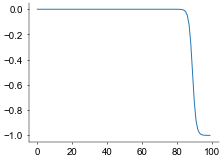

In [68]:
plt.plot(h[:, 2, 3])

In [76]:
Y = (np.random.randn(1, neurons, 1000) > 2.1).astype(float)
out, KL = flt.apply_filter(prng_state, Y)

(1, 5, 1, 1000)
(100, 5, 1, 1)


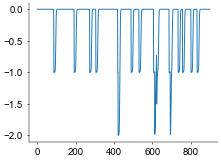

In [77]:
n = 0

plt.plot(out[0, n, :])

In [71]:
out.shape

(1, 5, 901)